<a href="https://colab.research.google.com/github/present42/PyTorchPractice/blob/main/Following_Jax_tutorial_(6)_Working_With_Pytrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with PyTrees

In [1]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3])
]

for pytree in example_trees:
  leaves = jax.tree_util.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x785142f9a210>]   has 3 leaves: [1, 'a', <object object at 0x785142f9a210>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


## Why Pytrees?

In ML, some places where you commonly find pytrees are:
- model parameters
- dataset entries
- RL agent observation



## Common pytree functions
`jax.tree_map`

In [2]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree.map(lambda x: x * 2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

In [3]:
another_list_of_lists = list_of_lists
jax.tree.map(lambda x, y: x+y, list_of_lists, another_list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

## Ex: ML model params

In [4]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,)))
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

In [5]:
jax.tree_map(lambda x: x.shape, params)

<ipython-input-5-8ef643eb55c2>:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(lambda x: x.shape, params)


[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [6]:
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)
  # Note that grads is a pytree with the same structure as params
  return jax.tree.map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

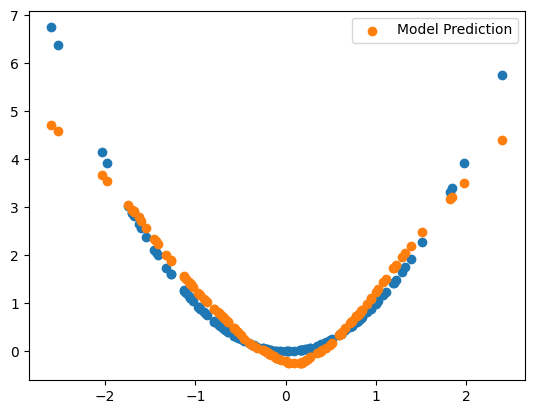

In [7]:
import matplotlib.pyplot as plt

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model Prediction')
plt.legend();

## Key paths

In [8]:
import collections
ATuple = collections.namedtuple('ATuple', ('name'))

tree = [1, {'k1': 2, 'k2': (3, 4)}, ATuple('foo')]
flattened, _ = jax.tree_util.tree_flatten_with_path(tree)
for key_path, value in flattened:
  print(f"Value of tree{jax.tree_util.keystr(key_path)}: {value}")

Value of tree[0]: 1
Value of tree[1]['k1']: 2
Value of tree[1]['k2'][0]: 3
Value of tree[1]['k2'][1]: 4
Value of tree[2].name: foo


To express key paths, JAX provides a few default key types for the built-in pytree node types:
 - SequenceKey(idx: int): for lists and tuples
 - DictKey(key: Hashable): for dictionaries
 - GetAttrKey(name: str): for namedtuples and preferably custom pytree nodes

In [9]:
for key_path, _ in flattened:
  print(f"Key path of tree{jax.tree_util.keystr(key_path)}: {repr(key_path)}")


Key path of tree[0]: (SequenceKey(idx=0),)
Key path of tree[1]['k1']: (SequenceKey(idx=1), DictKey(key='k1'))
Key path of tree[1]['k2'][0]: (SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=0))
Key path of tree[1]['k2'][1]: (SequenceKey(idx=1), DictKey(key='k2'), SequenceKey(idx=1))
Key path of tree[2].name: (SequenceKey(idx=2), GetAttrKey(name='name'))


## Custom pytree nodes

In [10]:
class MyContainer:
  def __init__(self, name: str, a: int, b: int, c: int):
    self.name = name
    self.a = a
    self.b = b
    self.c = c

In [11]:
jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6),
])

In [12]:
try:
  jax.tree_map(lambda x: x + 1, [
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6),
  ])
except TypeError as e:
  print(f"TypeError: {e}")

TypeError: unsupported operand type(s) for +: 'MyContainer' and 'int'


<ipython-input-12-888c6308ae65>:2: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(lambda x: x + 1, [


To solve this, we need to register our container with JAX by telling it how to flatten and unflatten it:

In [14]:
from typing import Iterable

def flatten_MyContainer(container) -> tuple[Iterable[int], str]:
  flat_contents = [container.a, container.b, container.c]

  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyContainer(
    aux_data: str, flat_contents: Iterable[int]
) -> MyContainer:
  return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(
    MyContainer, flatten_MyContainer, unflatten_MyContainer
)

jax.tree_util.tree_leaves([
    MyContainer('Alice', 1, 2, 3),
    MyContainer('Bob', 4, 5, 6)
])

[1, 2, 3, 4, 5, 6]

In [17]:
class MyKeyPathContainer(MyContainer):
  pass

def flatten_with_keys_MyKeyPathContainer(container) -> tuple[Iterable[int], str]:
  flat_contents = [(jax.tree_util.GetAttrKey('a'), container.a),
                   (jax.tree_util.GetAttrKey('b'), container.b),
                   (jax.tree_util.GetAttrKey('c'), container.c)
                   ]

  aux_data = container.name
  return flat_contents, aux_data

def unflatten_MyKeyPathContainer(
    aux_data: str, flat_contents: Iterable[str]
) -> MyKeyPathContainer:
  return MyKeyPathContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_with_keys(
    MyKeyPathContainer, flatten_with_keys_MyKeyPathContainer, unflatten_MyKeyPathContainer
)

jax.tree_util.tree_leaves([
    MyKeyPathContainer('Alice', 1, 2, 3),
    MyKeyPathContainer('Bob', 4, 5, 6),
])

[1, 2, 3, 4, 5, 6]

When a container registered with `register_pytree_node` uses `.*_with_path` APIs, the keys being returned will be a series of "flat index" fallbacks:

In [18]:
flattened, _ = jax.tree_util.tree_flatten_with_path(MyContainer('Alice', 1, 2, 3))


In [20]:
for key_path, value in flattened:
  print(f"MyContainer container{jax.tree_util.keystr(key_path)}: {value}")

MyContainer container[<flat index 0>]: 1
MyContainer container[<flat index 1>]: 2
MyContainer container[<flat index 2>]: 3


In [24]:
flattened, _ = jax.tree_util.tree_flatten_with_path(MyKeyPathContainer('Alice', 1, 2, 3))

In [25]:
for key_path, value in flattened:
  print(f"MyKeyPathContainer container{jax.tree_util.keystr(key_path)}: {value}")

MyKeyPathContainer container.a: 1
MyKeyPathContainer container.b: 2
MyKeyPathContainer container.c: 3


In [26]:
from typing import NamedTuple, Any

class MyOtherContainer(NamedTuple):
  name: str
  a: Any
  b: Any
  c: Any

jax.tree_util.tree_leaves([
    MyOtherContainer('Alice', 1, 2, 3),
    MyOtherContainer('Bob', 4, 5, 6),
])

['Alice', 1, 2, 3, 'Bob', 4, 5, 6]

One shortcut is to use `jax.tree_util.register_static` to register a type as being a node without children:

In [28]:
from typing import NamedTuple, Any

@jax.tree_util.register_static
class StaticStr(str):
  pass

class YetAnotherContainer(NamedTuple):
  name: StaticStr
  a: Any
  b: Any
  c: Any

jax.tree_util.tree_leaves([
    YetAnotherContainer(StaticStr('Alice'), 1, 2, 3),
    YetAnotherContainer(StaticStr('Bob'), 4, 5, 6),
])

[1, 2, 3, 4, 5, 6]

# Common pytree gotchas and patterns

## Mistaking nodes for leaves

A common problem to look out for is accidentally introducing tree nodes instead of leaves

In [32]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: x.shape, a_tree)
jax.tree_map(jnp.ones, shapes)

<ipython-input-32-6e0653ed084d>:4: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  shapes = jax.tree_map(lambda x: x.shape, a_tree)
<ipython-input-32-6e0653ed084d>:5: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(jnp.ones, shapes)


[(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)),
 (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]

Two broadly applicable solutions:
 - Rewrite the code to avoid the intermediate `tree_map`
 - convert the tuple into an `np.array` or `jnp.array` which makes the entire sequence a leaf

In [36]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

jax.tree.map(lambda x: jnp.ones(x.shape), a_tree)

[Array([[1., 1., 1.],
        [1., 1., 1.]], dtype=float32),
 Array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], dtype=float32)]

In [34]:
a_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

shapes = jax.tree.map(lambda x: jnp.array(x.shape), a_tree)
jax.tree.map(jnp.ones, shapes)

[Array([[1., 1., 1.],
        [1., 1., 1.]], dtype=float32),
 Array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], dtype=float32)]

## Handling of None

`jax.tree_utils` treats `None` as a node without children, not as a leaf:

In [37]:
jax.tree_util.tree_leaves([None, None, None])

[]

# Patterns

## Transposing trees
 : turn a list of trees to a tree of lists

In [38]:
def tree_transpose(list_of_trees):
  return jax.tree.map(lambda *xs: list(xs), *list_of_trees)

# Convert a dataset from row-major to column-major
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)


{'obs': [3, 4], 't': [1, 2]}

For more complicated transposes, JAX provides `jax.tree_transpose`, which is more verbose, but allows you specify the structure of the inner and outer Pytree for more flexibility

In [40]:
jax.tree_transpose(
    outer_treedef = jax.tree_structure([0 for e in episode_steps]),
    inner_treedef = jax.tree_structure(episode_steps[0]),
    pytree_to_transpose = episode_steps
)

<ipython-input-40-911dc382b376>:1: DeprecationWarning: jax.tree_transpose is deprecated: use jax.tree.transpose (jax v0.4.25 or newer) or jax.tree_util.tree_transpose (any JAX version).
  jax.tree_transpose(
<ipython-input-40-911dc382b376>:2: DeprecationWarning: jax.tree_structure is deprecated: use jax.tree.structure (jax v0.4.25 or newer) or jax.tree_util.tree_structure (any JAX version).
  outer_treedef = jax.tree_structure([0 for e in episode_steps]),
<ipython-input-40-911dc382b376>:3: DeprecationWarning: jax.tree_structure is deprecated: use jax.tree.structure (jax v0.4.25 or newer) or jax.tree_util.tree_structure (any JAX version).
  inner_treedef = jax.tree_structure(episode_steps[0]),


{'obs': [3, 4], 't': [1, 2]}